# Illustrate the Word2Vec Embedding Layer on Trip Advisor Review Dataset

In [1]:
import pandas as pd
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import remove_stopwords
from keras.utils import to_categorical
pd.set_option('max_colwidth', 300)

Using TensorFlow backend.


In [2]:
 # Note you should have 4.1.2
print("gensim version is",gensim.__version__ )
if gensim.__version__ != '4.1.2':
    print ("Note you need to update gensim using pip install -U gensum")

gensim version is 4.1.2


# 1. Some constants 

In [3]:
max_review_length = 300 # no of words per review.  reviews will be  truncated or padded to be of this length.
max_words = 10000        # this is the size of the index (i.e. most common top words that will be used as features)                       # note code assumes there are enough words in reviews.
embedding_dim = 100    # size of embedding.
traning_samples= 10000
validation_samples = 6000

# 2. Reading in the data

In [4]:

data_dir = "./data"
tripadvisor_df = pd.read_csv(os.path.join( data_dir, 'tripadvisor_hotel_reviews.csv.zip'))
print(" tripadvisor_df shape: ", tripadvisor_df.shape)
tripadvisor_df.head()
               

 tripadvisor_df shape:  (20491, 2)


,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites descr...",2
2,"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't pro...",3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big striped curtains pulled closed nice touch felt cosy, goldfish named brandi enjoyed, did n't partake f...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, problem taxi driver did n't want accept voucher barely spoke english, funny thing speak arabic called sta...",5


# 3. Data Analysis and Visualisation

Text(0.5, 1.0, ' Class Distribution Tripadvisor Hotel Reviews  ')

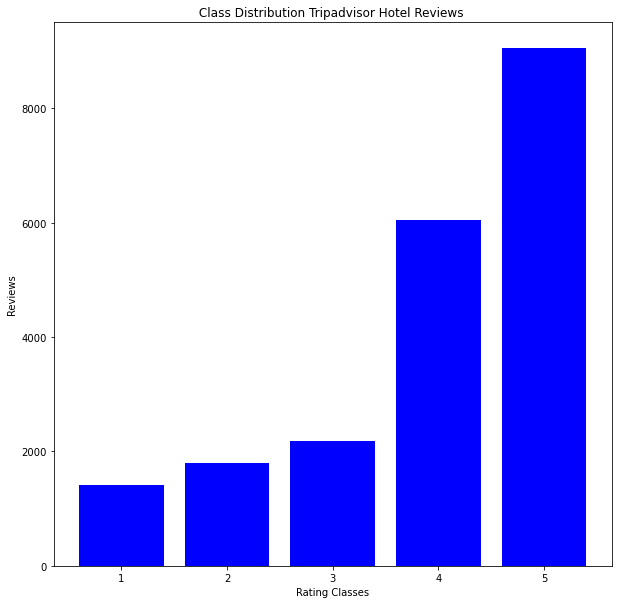

In [5]:
rating_counts = tripadvisor_df['Rating'].value_counts()

plt.figure(figsize=(10,10))

plt.bar( rating_counts.index , rating_counts.values , color="blue")
              
plt.xlabel("Rating Classes")
plt.ylabel("Reviews")
plt.title(" Class Distribution Tripadvisor Hotel Reviews  ")


In [6]:
texts = tripadvisor_df['Review'].values
print(texts[10])

poor value stayed monaco seattle july, nice hotel priced 100- 150 night not, hotel takes beating quotient, experience simply average, nothing exceptional paying 300+ n't ca n't terribly disappointed, wife stayed nicest suites 200/night felt like overpaying, best advice shop, quality-wise league average marriott nice best western,  


In [7]:
def prepare_text(texts):
    final_text = []
    for txt in texts:
        text = remove_stopwords(txt)
        text_tokenised = gensim.utils.simple_preprocess(text) # does some simple toxenisation
        final_text.append(text_tokenised)
    return final_text
        
reviews = prepare_text(texts)

for i in range(10):
    print(f"{i} review: {reviews[i][0:8]}")

0 review: ['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay']
1 review: ['ok', 'special', 'charge', 'diamond', 'member', 'hilton', 'decided', 'chain']
2 review: ['nice', 'rooms', 'experience', 'hotel', 'monaco', 'seattle', 'good', 'hotel']
3 review: ['unique', 'great', 'stay', 'wonderful', 'time', 'hotel', 'monaco', 'location']
4 review: ['great', 'stay', 'great', 'stay', 'went', 'seahawk', 'game', 'awesome']
5 review: ['love', 'monaco', 'staff', 'husband', 'stayed', 'hotel', 'crazy', 'weekend']
6 review: ['cozy', 'stay', 'rainy', 'city', 'husband', 'spent', 'nights', 'monaco']
7 review: ['excellent', 'staff', 'housekeeping', 'quality', 'hotel', 'chocked', 'staff', 'feel']
8 review: ['hotel', 'stayed', 'hotel', 'monaco', 'cruise', 'rooms', 'generous', 'decorated']
9 review: ['excellent', 'stayed', 'hotel', 'monaco', 'past', 'delight', 'reception', 'staff']


# 4. Use W2V method to produce the word to vec mappings 

In [8]:
model = gensim.models.Word2Vec(
        reviews,
        vector_size=embedding_dim, # size of representation  old version of gensim has size = ...
        window=5,            # length of frame for neighbours
        # sg = 0 for CBOW, sg = 1 for skipgram.  default is 0
        #iter = 5   no of epochs for w2v. default is 5
        min_count=2)       

In [9]:
index_to_key = model.wv.index_to_key # different in older versions

print(f"index_to_key is a list with {len(index_to_key)} words, sample is:")
for index, word in enumerate(index_to_key):
    if index == 10:
        break
    print(f"\tword {index} == {word}")

index_to_key is a list with 25354 words, sample is:
	word 0 == hotel
	word 1 == room
	word 2 == great
	word 3 == good
	word 4 == staff
	word 5 == stay
	word 6 == nice
	word 7 == rooms
	word 8 == location
	word 9 == stayed


In [10]:
# Encode target variable Rating, into a one hot vector.
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }
labels = ['1', '2', '3', '4', '5']

ratings = tripadvisor_df['Rating'].copy()
ratings.replace(encoding, inplace=True)
ratings = to_categorical(ratings,5)

# 5. Code the sentences and set up the training and validation sets

In [11]:
# Once we have the index_to_key, we can construct the word_index and also use it to code the sentences.
# the coded sentences are then made into a fixed size using pad_sequences
from keras_preprocessing.sequence import pad_sequences

word_index = {w: i+1 for i,w in enumerate(index_to_key) if i < max_words-1}  # Keep just max_words (zero is reserved for unknown)

sequences = [[word_index.get(w, 0) for w in sent] for sent in reviews] # code the sentences

seqs_truncated = pad_sequences(sequences, maxlen=max_review_length, padding="pre", truncating="post")

print("Line 1 :", reviews[1])
print("\nCoded :  " , seqs_truncated[1])

Line 1 : ['ok', 'special', 'charge', 'diamond', 'member', 'hilton', 'decided', 'chain', 'shot', 'th', 'anniversary', 'seattle', 'start', 'booked', 'suite', 'paid', 'extra', 'website', 'description', 'not', 'suite', 'bedroom', 'bathroom', 'standard', 'hotel', 'room', 'took', 'printed', 'reservation', 'desk', 'showed', 'said', 'things', 'like', 'tv', 'couch', 'ect', 'desk', 'clerk', 'told', 'oh', 'mixed', 'suites', 'description', 'kimpton', 'website', 'sorry', 'free', 'breakfast', 'got', 'kidding', 'embassy', 'suits', 'sitting', 'room', 'bathroom', 'bedroom', 'unlike', 'kimpton', 'calls', 'suite', 'day', 'stay', 'offer', 'correct', 'false', 'advertising', 'send', 'kimpton', 'preferred', 'guest', 'website', 'email', 'asking', 'failure', 'provide', 'suite', 'advertised', 'website', 'reservation', 'description', 'furnished', 'hard', 'copy', 'reservation', 'printout', 'website', 'desk', 'manager', 'duty', 'reply', 'solution', 'send', 'email', 'trip', 'guest', 'survey', 'follow', 'email', 'ma

In [12]:
max_length = max([len(x) for x in seqs_truncated])
vocab_size = len(word_index)+1 #add 1 to account for unknown word
print("Vocabulary size: {}".format(vocab_size))
print("Max length of sentence: {}".format(max_length))

Vocabulary size: 10000
Max length of sentence: 300


In [13]:
# Create fixed size sequences
import numpy as np

data = pad_sequences(seqs_truncated , maxlen = max_length)

ratings = np.asarray(ratings)
print( 'Shape of data = ' , data.shape)
print( 'Shape of Lables = ' ,  ratings.shape)


Shape of data =  (20491, 300)
Shape of Lables =  (20491, 5)


## Below function creates the training, testing and validation sets:

As most the ratings are 5-star ratings and the least are 1-star ratings. Thus stratifing the dataset ensure that the distribution of all the classes is even between the train, validation, and test set.

In [14]:

from sklearn.model_selection import train_test_split
 
def create_training_validation_sets(data,labels,test_size):

    x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size= test_size , shuffle=True , random_state=42 , stratify = ratings )

    return x_train, x_val, y_train, y_val



x_train, x_val, y_train, y_val = create_training_validation_sets(data, ratings, 0.1)

print( "x_train size = " , str( len(x_train)))
print("x_val size = " , str(len( x_val)))
print("y_train size = " , str(len( y_train )))
print( "y_val size = " , str(len( y_val )))

x_train size =  18441
x_val size =  2050
y_train size =  18441
y_val size =  2050


# 6. Define a function for creating the embedding matrix

In [15]:
# Function returns wv_matrix ready for a Keras Embeddings layer.  wv is the mapping from word to vector.
def load_embeddings_into_wv(wv):
    
    wv_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i >= max_words:  
            continue
        try:
            embedding_vector = wv[word]
            wv_matrix[i] = embedding_vector
        except:
            pass    
    return wv_matrix


In [16]:
wv_matrix = load_embeddings_into_wv(model.wv)


# 7.Define LSTM Network

In [17]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

network_lstm = Sequential()
network_lstm.add(Embedding(max_words, embedding_dim, input_length=max_length, weights=[wv_matrix], trainable=False))
network_lstm.add(Bidirectional(LSTM(64)))
network_lstm.add(Dropout(0.5))
network_lstm.add(Dense(128, activation='relu'))
network_lstm.add(Dropout(0.5))
network_lstm.add(Dense(64, activation='relu'))
network_lstm.add(Dropout(0.5))
network_lstm.add(Dense(5 , activation = 'softmax'))
network_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [18]:
network_lstm.compile(optimizer= 'Adam' , loss= 'mse' , metrics= ['acc'])
hist_lstm = network_lstm.fit( x_train , y_train , epochs= 20 , batch_size= 32 , validation_data= (x_val,y_val))

Epoch 1/20
577/577 [==============================] - 127s 212ms/step - loss: 0.1289 - acc: 0.4605 - val_loss: 0.1106 - val_acc: 0.5312
Epoch 2/20
577/577 [==============================] - 117s 203ms/step - loss: 0.1142 - acc: 0.5430 - val_loss: 0.1052 - val_acc: 0.5766
Epoch 3/20
577/577 [==============================] - 124s 214ms/step - loss: 0.1072 - acc: 0.5818 - val_loss: 0.1030 - val_acc: 0.6141
Epoch 4/20
577/577 [==============================] - 128s 221ms/step - loss: 0.1042 - acc: 0.5924 - val_loss: 0.0977 - val_acc: 0.6234
Epoch 5/20
577/577 [==============================] - 122s 212ms/step - loss: 0.1016 - acc: 0.6117 - val_loss: 0.1004 - val_acc: 0.6049
Epoch 6/20
577/577 [==============================] - 90s 157ms/step - loss: 0.0997 - acc: 0.6191 - val_loss: 0.0980 - val_acc: 0.6176
Epoch 7/20
577/577 [==============================] - 88s 153ms/step - loss: 0.0978 - acc: 0.6266 - val_loss: 0.0959 - val_acc: 0.6312
Epoch 8/20
577/577 [==============================

In [19]:
network_lstm.save('models/network_w2v_lstm')

INFO:tensorflow:Assets written to: models/network_w2v_lstm\assets


INFO:tensorflow:Assets written to: models/network_w2v_lstm\assets


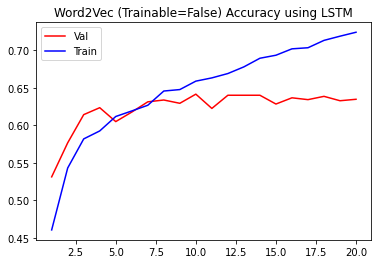

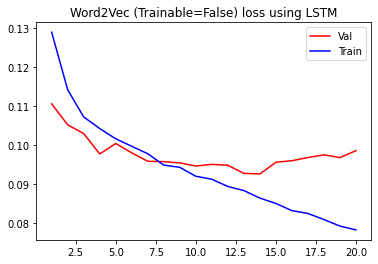

In [20]:
acc_lstm = hist_lstm.history['acc']
val_acc_lstm= hist_lstm.history['val_acc']

epochs = range(1,len(acc_lstm)+1)

plt.plot(epochs , val_acc_lstm ,'r' ,label= 'Val')

plt.title("Word2Vec (Trainable=False) Accuracy using LSTM")
plt.plot(epochs , acc_lstm ,'b' ,label= 'Train')

plt.legend()
plt.show()


loss_lstm = hist_lstm.history['loss']
val_loss_lstm= hist_lstm.history['val_loss']

epochs = range(1,len(loss_lstm)+1)

plt.plot(epochs , val_loss_lstm ,'r' ,label= 'Val')

plt.title("Word2Vec (Trainable=False) loss using LSTM")
plt.plot(epochs , loss_lstm ,'b' ,label= 'Train')


plt.legend()
plt.show()

# 8. Define LSTM for W2V (trainable=True)

In [19]:

network_lstm_trainable = Sequential()
network_lstm_trainable.add(Embedding(max_words, embedding_dim, input_length=max_length, weights=[wv_matrix], trainable=True))
network_lstm_trainable.add(Bidirectional(LSTM(64)))
network_lstm_trainable.add(Dropout(0.5))
network_lstm_trainable.add(Dense(128, activation='relu'))
network_lstm_trainable.add(Dropout(0.5))
network_lstm_trainable.add(Dense(64, activation='relu'))
network_lstm_trainable.add(Dropout(0.5))
network_lstm_trainable.add(Dense(5 , activation = 'softmax'))
network_lstm_trainable.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [20]:
network_lstm_trainable.compile(optimizer= 'Adam' , loss= 'mse' , metrics= ['acc'])
hist_lstm_trainable = network_lstm_trainable.fit( x_train , y_train , epochs= 20 , batch_size= 32 , validation_data= (x_val,y_val))

Epoch 1/20
577/577 [==============================] - 144s 243ms/step - loss: 0.1287 - acc: 0.4701 - val_loss: 0.1318 - val_acc: 0.4180
Epoch 2/20
577/577 [==============================] - 108s 187ms/step - loss: 0.1135 - acc: 0.5435 - val_loss: 0.1070 - val_acc: 0.5707
Epoch 3/20
577/577 [==============================] - 105s 181ms/step - loss: 0.1088 - acc: 0.5700 - val_loss: 0.1012 - val_acc: 0.6015
Epoch 4/20
577/577 [==============================] - 109s 190ms/step - loss: 0.1002 - acc: 0.6153 - val_loss: 0.0992 - val_acc: 0.6102
Epoch 5/20
577/577 [==============================] - 108s 187ms/step - loss: 0.0935 - acc: 0.6534 - val_loss: 0.0950 - val_acc: 0.6224
Epoch 6/20
577/577 [==============================] - 102s 178ms/step - loss: 0.0885 - acc: 0.6741 - val_loss: 0.0956 - val_acc: 0.6278
Epoch 7/20
577/577 [==============================] - 94s 163ms/step - loss: 0.0816 - acc: 0.7085 - val_loss: 0.0983 - val_acc: 0.6288
Epoch 8/20
577/577 [=============================

In [22]:
network_lstm_trainable.save('models/network_lstm_trainable')

INFO:tensorflow:Assets written to: models/network_lstm_trainable\assets


INFO:tensorflow:Assets written to: models/network_lstm_trainable\assets


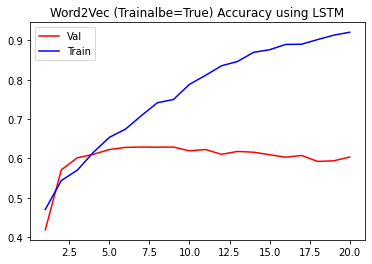

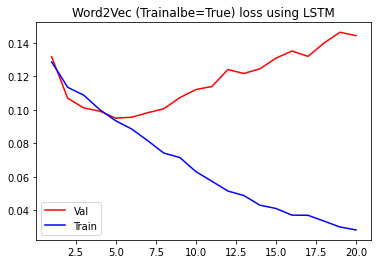

In [23]:
acc_lstm_trainable = hist_lstm_trainable.history['acc']
val_acc_lstm_trainable = hist_lstm_trainable.history['val_acc']


epochs = range(1,len(acc_lstm_trainable)+1)

plt.plot(epochs , val_acc_lstm_trainable ,'r' ,label= 'Val')


plt.title("Word2Vec (Trainalbe=True) Accuracy using LSTM")
plt.plot(epochs , acc_lstm_trainable ,'b' ,label= 'Train')

plt.legend()
plt.show()

loss_lstm_trainable = hist_lstm_trainable.history['loss']
val_loss_lstm_trainable= hist_lstm_trainable.history['val_loss']

epochs = range(1,len(loss_lstm_trainable)+1)

plt.plot(epochs , val_loss_lstm_trainable ,'r' ,label= 'Val')

plt.title("Word2Vec (Trainalbe=True) loss using LSTM")
plt.plot(epochs , loss_lstm_trainable ,'b' ,label= 'Train')

plt.legend()
plt.show()

# 5. Define a Network

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten , Dense

network = Sequential()
network.add(Embedding(max_words , embedding_dim , input_length =  max_length, weights=[wv_matrix] , trainable = False))
network.add(Flatten())
network.add(Dense(32 , activation = 'relu'))
network.add(Dense(5 , activation = 'softmax'))
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 1,960,197
Trainable params: 960,197
Non-trainable params: 1,000,000
_________________________________________________________________


In [18]:
network.compile(optimizer= 'rmsprop' , loss= 'binary_crossentropy' , metrics= ['acc'])
hist = network.fit( x_train , y_train , epochs= 20 , batch_size= 32 , validation_data= (x_val,y_val))

Train on 18441 samples, validate on 2050 samples
Epoch 1/20
18441/18441 [==============================] - 8s 429us/step - loss: 0.3737 - acc: 0.8291 - val_loss: 0.3489 - val_acc: 0.8384
Epoch 2/20
18441/18441 [==============================] - 7s 402us/step - loss: 0.2957 - acc: 0.8595 - val_loss: 0.3642 - val_acc: 0.8289
Epoch 3/20
18441/18441 [==============================] - 8s 410us/step - loss: 0.2308 - acc: 0.8934 - val_loss: 0.4156 - val_acc: 0.8212
Epoch 4/20
18441/18441 [==============================] - 7s 402us/step - loss: 0.1707 - acc: 0.9265 - val_loss: 0.5060 - val_acc: 0.8158
Epoch 5/20
18441/18441 [==============================] - 8s 430us/step - loss: 0.1221 - acc: 0.9503 - val_loss: 0.6105 - val_acc: 0.8041
Epoch 6/20
18441/18441 [==============================] - 8s 413us/step - loss: 0.0837 - acc: 0.9671 - val_loss: 0.7648 - val_acc: 0.8039
Epoch 7/20
18441/18441 [==============================] - 7s 405us/step - loss: 0.0566 - acc: 0.9792 - val_loss: 0.8903 - v

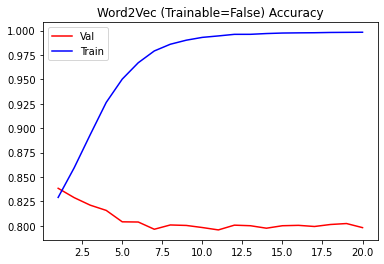

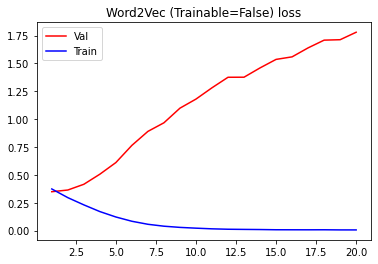

In [19]:
import matplotlib.pyplot as plt


acc= hist.history['acc']
val_acc= hist.history['val_acc']

# acc = hist['acc']
# val_acc= hist.history['val_acc']

epochs = range(1,len(acc)+1)

plt.plot(epochs , val_acc ,'r' ,label= 'Val')
# plt.plot(epochs , val_acc, 'b', label= 'Without Glove')

# plt.legend()
# plt.show()

plt.title("Word2Vec (Trainable=False) Accuracy")
plt.plot(epochs , acc ,'b' ,label= 'Train')
# plt.plot(epochs , acc, 'b', label= 'Without Glove')

plt.legend()
plt.show()



loss = hist.history['loss']
val_loss= hist.history['val_loss']

# loss = hist['loss']
# val_loss= hist.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs , val_loss ,'r' ,label= 'Val')
# plt.plot(epochs , val_loss, 'b', label= 'Without Glove')

# plt.legend()
# plt.show()

plt.title("Word2Vec (Trainable=False) loss")
plt.plot(epochs , loss ,'b' ,label= 'Train')
# plt.plot(epochs , loss, 'b', label= 'Without Glove')

plt.legend()
plt.show()
